In [1]:
import pandas as pd 
import numpy as np
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [2]:
# read data
data_for_model = pd.read_csv('Combined Station Data.csv')
#data_for_model.drop(columns=['anomaly'], inplace=True)
data_for_model

,Date,Wind,Wind Dir,SO2,NO2,NOX,PM10,PM2.5,Pressure,Temp,NO1,Date Time,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Chicken Farm,Location_Marapong,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend
0,2016/01/15 16:10:00,5.726794,101.24370,25.67,0.808,18.10,131.10,56.570,843.0,22.97,22.440,2016-01-15 16:10:00,16,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.726794,NaN,5.726794,NaN,5.726794,NaN,5.726794,NaN,101.243700,NaN,101.243700,NaN,101.243700,NaN,101.243700,NaN,25.670000,NaN,25.670000,NaN,25.670000,NaN,25.670000,NaN,0.808000,NaN,0.808000,NaN,0.808000,NaN,0.808000,NaN,18.100000,NaN,18.100000,NaN,18.100000,NaN,18.100000,NaN,131.100000,NaN,131.100000,NaN,131.100000,NaN,131.100000,NaN,56.570000,NaN,56.570000,NaN,56.570000,NaN,56.570000,NaN,843.000000,NaN,843.000000,NaN,843.000000,NaN,843.000000,NaN,22.970000,NaN,22.970000,NaN,22.970000,NaN,22.970000,NaN,22.440000,NaN,22.440000,NaN,22.440000,NaN,22.440000,NaN,True,False,False,False,False,True,False,True,False
1,2016/01/15 16:20:00,5.942719,101.66950,20.56,1.167,17.69,130.70,46.890,844.0,22.58,18.970,2016-01-15 16:20:00,16,1,4,5.726794,101.24370,25.67,0.808,18.10,131.10,56.570,843.0,22.97,22.440,5.834757,0.152682,5.834757,0.152682,5.834757,0.152682,5.834757,0.152682,101.456600,0.301086,101.456600,0.301086,101.456600,0.301086,101.456600,0.301086,23.115000,3.613316,23.115000,3.613316,23.115000,3.613316,23.115000,3.613316,0.987500,0.253851,0.987500,0.253851,0.987500,0.253851,0.987500,0.253851,17.895000,0.289914,17.895000,0.289914,17.895000,0.289914,17.895000,0.289914,130.900000,0.282843,130.900000,0.282843,130.900000,0.282843,130.900000,0.282843,51.730000,6.844794,51.730000,6.844794,51.730000,6.844794,51.730000,6.844794,843.500000,0.707107,843.500000,0.707107,843.500000,0.707107,843.500000,0.707107,22.775000,0.275772,22.775000,0.275772,22.775000,0.275772,22.775000,0.275772,20.705000,2.453661,20.705000,2.453661,20.705000,2.453661,20.705000,2.453661,True,False,False,False,False,True,False,True,False
2,2016/01/15 16:30:00,6.538234,94.81412,17.24,1.212,12.66,141.30,51.600,843.0,22.84,15.760,2016-01-15 16:30:00,16,1,4,5.942719,101.66950,20.56,1.167,17.69,130.70,46.890,844.0,22.58,18.970,6.069249,0.420257,6.069249,0.420257,6.069249,0.420257,6.069249,0.420257,99.242440,3.840943,99.242440,3.840943,99.242440,3.840943,99.242440,3.840943,21.156667,4.246555,21.156667,4.246555,21.156667,4.246555,21.156667,4.246555,1.062333,0.221405,1.062333,0.221405,1.062333,0.221405,1.062333,0.221405,16.150000,3.029373,16.150000,3.029373,16.150000,3.029373,16.150000,3.029373,13

In [3]:
location_cols = [col for col in data_for_model.columns if col.startswith('Location_')]

def decode_location(row):
    for col in location_cols:
        if row[col] == 1:
            return col.replace('Location_', '')
    return 'Unknown'

data_for_model['Location'] = data_for_model.apply(decode_location, axis=1)


data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
locations = data_for_model['Location'].unique()

In [4]:
features_to_keep = [
    'Hour', 'Month', 'DayOfWeek', 'Date Time',

    'Wind', 'Wind_lag1', 'Wind_roll3_mean', 'Wind_roll6_mean', 'Wind_roll12_mean', 'Wind_roll24_mean',
    'Pressure', 'Pressure_lag1', 'Pressure_roll3_mean', 'Pressure_roll6_mean', 'Pressure_roll12_mean', 'Pressure_roll24_mean',
    'Temp', 'Temp_lag1', 'Temp_roll3_mean', 'Temp_roll6_mean', 'Temp_roll12_mean', 'Temp_roll24_mean',
    
    'SO2', 'SO2_lag1', 'SO2_roll3_mean', 'SO2_roll6_mean', 'SO2_roll12_mean', 'SO2_roll24_mean',
    'NO2', 'NO2_lag1', 'NO2_roll3_mean', 'NO2_roll6_mean', 'NO2_roll12_mean', 'NO2_roll24_mean',
    'NOX', 'NOX_lag1', 'NOX_roll3_mean', 'NOX_roll6_mean', 'NOX_roll12_mean', 'NOX_roll24_mean',
    'PM10', 'PM10_lag1', 'PM10_roll3_mean', 'PM10_roll6_mean', 'PM10_roll12_mean', 'PM10_roll24_mean',
    'PM2.5', 'PM2.5_lag1', 'PM2.5_roll3_mean', 'PM2.5_roll6_mean', 'PM2.5_roll12_mean', 'PM2.5_roll24_mean',

    'Location_Chicken Farm', 'Location_Marapong', 'Location_Phola',  # if using one-hot
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',  # only if proven useful
]

data_for_model= data_for_model[features_to_keep]
data_for_model

,Hour,Month,DayOfWeek,Date Time,Wind,Wind_lag1,Wind_roll3_mean,Wind_roll6_mean,Wind_roll12_mean,Wind_roll24_mean,Pressure,Pressure_lag1,Pressure_roll3_mean,Pressure_roll6_mean,Pressure_roll12_mean,Pressure_roll24_mean,Temp,Temp_lag1,Temp_roll3_mean,Temp_roll6_mean,Temp_roll12_mean,Temp_roll24_mean,SO2,SO2_lag1,SO2_roll3_mean,SO2_roll6_mean,SO2_roll12_mean,SO2_roll24_mean,NO2,NO2_lag1,NO2_roll3_mean,NO2_roll6_mean,NO2_roll12_mean,NO2_roll24_mean,NOX,NOX_lag1,NOX_roll3_mean,NOX_roll6_mean,NOX_roll12_mean,NOX_roll24_mean,PM10,PM10_lag1,PM10_roll3_mean,PM10_roll6_mean,PM10_roll12_mean,PM10_roll24_mean,PM2.5,PM2.5_lag1,PM2.5_roll3_mean,PM2.5_roll6_mean,PM2.5_roll12_mean,PM2.5_roll24_mean,Location_Chicken Farm,Location_Marapong,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,16,1,4,2016-01-15 16:10:00,5.726794,NaN,5.726794,5.726794,5.726794,5.726794,843.0,NaN,843.000000,843.000000,843.000000,843.000000,22.97,NaN,22.970000,22.970000,22.970000,22.970000,25.67,NaN,25.670000,25.670000,25.670000,25.670000,0.808,NaN,0.808000,0.808000,0.808000,0.808000,18.10,NaN,18.100000,18.100000,18.100000,18.100000,131.10,NaN,131.100000,131.100000,131.100000,131.100000,56.570,NaN,56.570000,56.570000,56.570000,56.570000,True,False,False,False,False,True,False
1,16,1,4,2016-01-15 16:20:00,5.942719,5.726794,5.834757,5.834757,5.834757,5.834757,844.0,843.0,843.500000,843.500000,843.500000,843.500000,22.58,22.97,22.775000,22.775000,22.775000,22.775000,20.56,25.67,23.115000,23.115000,23.115000,23.115000,1.167,0.808,0.987500,0.987500,0.987500,0.987500,17.69,18.10,17.895000,17.895000,17.895000,17.895000,130.70,131.10,130.900000,130.900000,130.900000,130.900000,46.890,56.570,51.730000,51.730000,51.730000,51.730000,True,False,False,False,False,True,False
2,16,1,4,2016-01-15 16:30:00,6.538234,5.942719,6.069249,6.069249,6.069249,6.069249,843.0,844.0,843.333333,843.333333,843.333333,843.333333,22.84,22.58,22.796667,22.796667,22.796667,22.796667,17.24,20.56,21.156667,21.156667,21.156667,21.156667,1.212,1.167,1.062333,1.062333,1.062333,1.062333,12.66,17.69,16.150000,16.150000,16.150000,16.150000,141.30,130.70,134.366667,134.366667,134.366667,134.366667,51.600,46.890,51.686667,51.686667,51.686667,51.686667,True,False,False,False,False,True,False
3,16,1,4,2016-01-15 16:40:00,7.156286,6.538234,6.545746,6.341008,6.341008,6.341008,844.0,843.0,843.666667,843.500000,843.500000,843.500000,22.32,22.84,22.580000,22.677500,22.677500,22.677500,13.81,17.24,17.203333,19.320000,19.320000,19.320000,1.324,1.212,1.234333,1.127750,1.127750,1.127750,10.92,12.66,13.756667,14.842500,14.842500,14.842500,146.10,141.30,139.366667,137.300000,137.300000,137.300000,53.250,51.600,50.580000,52.077500,52.077500,52.077500,True,False,False,False,False,True,False
4,16,1,4,2016-01-15 16:50:00,6.355300,7.156286,6.683273,6.343867,6.343867,6.343867,844.0,844.0,843.666667,843.600000,843.600000,843.600000,21.94,22.32,22.366667,22.530000,22.530000,22.530000,9.97,13.81,13.673333,17.450000,17.450000,17.450000,1.302,1.324,1.279333,1.162600,1.162600,1.162600,13.42,10.92,12.333333,14.558000,14.558000,14.558000,146.40,146.10,144.600000,139.120000,139.120000,139.120000,51.610,53.250,52.153333,51.984000,51.984000,51.984000,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348626,14,2,1,2018-02-20 14:00:00,1.951017,2.756740,2.463012,2.633396,2.657896,2.671371,848.0,848.0,848.000000,848.000000,848.416667,849.041667,26.51,26.35,26.403333,26.176667,25.552500,24.439583,NaN,NaN,NaN,NaN,NaN,NaN,6.792,8.390,7.787333,8.713667,9.097583,12.335042,11.18,15.27,14.060000,16.156667,16.924167,26.232083,10.14,19.42,17.286667,20.556667,21.910000,20.590042,0.074,0.110,0.092000,0.088167,0.093000,0.095208,False,False,True,False,False,True,False
348627,14,2,1,2018-02-20 14:10:00,2.108797,

In [5]:
data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
data_for_model['Year'] = data_for_model['Date Time'].dt.year


C:\Users\Shivm\AppData\Local\Temp\ipykernel_26984\4097665056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
C:\Users\Shivm\AppData\Local\Temp\ipykernel_26984\4097665056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['Year'] = data_for_model['Date Time'].dt.year


In [6]:
data_for_model.columns

Index(['Hour', 'Month', 'DayOfWeek', 'Date Time', 'Wind', 'Wind_lag1',
       'Wind_roll3_mean', 'Wind_roll6_mean', 'Wind_roll12_mean',
       'Wind_roll24_mean', 'Pressure', 'Pressure_lag1', 'Pressure_roll3_mean',
       'Pressure_roll6_mean', 'Pressure_roll12_mean', 'Pressure_roll24_mean',
       'Temp', 'Temp_lag1', 'Temp_roll3_mean', 'Temp_roll6_mean',
       'Temp_roll12_mean', 'Temp_roll24_mean', 'SO2', 'SO2_lag1',
       'SO2_roll3_mean', 'SO2_roll6_mean', 'SO2_roll12_mean',
       'SO2_roll24_mean', 'NO2', 'NO2_lag1', 'NO2_roll3_mean',
       'NO2_roll6_mean', 'NO2_roll12_mean', 'NO2_roll24_mean', 'NOX',
       'NOX_lag1', 'NOX_roll3_mean', 'NOX_roll6_mean', 'NOX_roll12_mean',
       'NOX_roll24_mean', 'PM10', 'PM10_lag1', 'PM10_roll3_mean',
       'PM10_roll6_mean', 'PM10_roll12_mean', 'PM10_roll24_mean', 'PM2.5',
       'PM2.5_lag1', 'PM2.5_roll3_mean', 'PM2.5_roll6_mean',
       'PM2.5_roll12_mean', 'PM2.5_roll24_mean', 'Location_Chicken Farm',
       'Location_Marapong', 'L

In [7]:
data_for_model['PM2.5_lag1'] = data_for_model['PM2.5'].shift(1)

# Rolling means with different windows, shifted by 1 to prevent leakage
data_for_model['PM2.5_roll3_mean'] = data_for_model['PM2.5'].rolling(window=3).mean().shift(1)
data_for_model['PM2.5_roll6_mean'] = data_for_model['PM2.5'].rolling(window=6).mean().shift(1)
data_for_model['PM2.5_roll12_mean'] = data_for_model['PM2.5'].rolling(window=12).mean().shift(1)
data_for_model['PM2.5_roll24_mean'] = data_for_model['PM2.5'].rolling(window=24).mean().shift(1)
data_for_model = data_for_model.dropna().reset_index(drop=True)
# # Split by year
df_train = data_for_model[data_for_model['Year'] == 2016]
df_test = data_for_model[data_for_model['Year'] == 2017]
df_val = data_for_model[data_for_model['Year'] == 2018]


C:\Users\Shivm\AppData\Local\Temp\ipykernel_26984\2169017664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['PM2.5_lag1'] = data_for_model['PM2.5'].shift(1)
C:\Users\Shivm\AppData\Local\Temp\ipykernel_26984\2169017664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_model['PM2.5_roll3_mean'] = data_for_model['PM2.5'].rolling(window=3).mean().shift(1)
C:\Users\Shivm\AppData\Local\Temp\ipykernel_26984\2169017664.py:5: SettingWithCopyWarning: 
A value is trying to be set on a co

In [8]:
data_for_model

,Hour,Month,DayOfWeek,Date Time,Wind,Wind_lag1,Wind_roll3_mean,Wind_roll6_mean,Wind_roll12_mean,Wind_roll24_mean,Pressure,Pressure_lag1,Pressure_roll3_mean,Pressure_roll6_mean,Pressure_roll12_mean,Pressure_roll24_mean,Temp,Temp_lag1,Temp_roll3_mean,Temp_roll6_mean,Temp_roll12_mean,Temp_roll24_mean,SO2,SO2_lag1,SO2_roll3_mean,SO2_roll6_mean,SO2_roll12_mean,SO2_roll24_mean,NO2,NO2_lag1,NO2_roll3_mean,NO2_roll6_mean,NO2_roll12_mean,NO2_roll24_mean,NOX,NOX_lag1,NOX_roll3_mean,NOX_roll6_mean,NOX_roll12_mean,NOX_roll24_mean,PM10,PM10_lag1,PM10_roll3_mean,PM10_roll6_mean,PM10_roll12_mean,PM10_roll24_mean,PM2.5,PM2.5_lag1,PM2.5_roll3_mean,PM2.5_roll6_mean,PM2.5_roll12_mean,PM2.5_roll24_mean,Location_Chicken Farm,Location_Marapong,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Year
0,20,1,4,2016-01-15 20:10:00,5.013026,6.535129,5.808405,5.669708,5.005227,5.390149,846.0,846.0,846.000000,846.000000,846.000000,845.250000,17.53,17.60,17.676667,17.860000,17.685000,19.031250,8.150,12.060,13.016667,12.320000,10.885000,10.724625,1.122,0.853,1.010000,1.036167,1.202667,1.286875,4.242,7.925,7.695667,7.931333,7.243500,7.783167,27.390,57.750,53.926667,81.613333,88.217500,102.378750,13.810,31.680,41.970000,49.580000,54.111667,48.655417,True,False,False,False,False,True,False,2016
1,20,1,4,2016-01-15 20:20:00,4.576110,5.013026,5.374755,5.538088,5.002518,5.333207,847.0,846.0,846.333333,846.166667,846.083333,845.375000,17.48,17.53,17.536667,17.763333,17.725833,18.818750,9.410,8.150,9.873333,12.226667,10.988333,10.260042,1.257,1.122,1.077333,1.043667,1.193333,1.290625,6.268,4.242,6.145000,7.707500,7.337667,7.307250,6.130,27.390,30.423333,63.201667,82.490000,97.188333,4.857,13.810,29.956667,42.018333,51.283333,46.873750,True,False,False,False,False,True,False,2016
2,20,1,4,2016-01-15 20:30:00,5.604620,4.576110,5.064585,5.558342,5.178374,5.294307,847.0,847.0,846.666667,846.333333,846.166667,845.541667,17.56,17.48,17.523333,17.676667,17.747500,18.598750,9.590,9.410,9.050000,12.028333,11.012500,9.941292,1.324,1.257,1.234333,1.084833,1.189583,1.295292,9.060,6.268,6.523333,7.870833,7.486333,7.157250,4.019,6.130,12.513000,45.054833,76.335750,91.468292,4.540,4.857,16.782333,33.312833,47.258917,45.122375,True,False,False,False,False,True,False,2016
3,20,1,4,2016-01-15 20:40:00,4.630336,5.604620,4.937022,5.372713,5.245980,5.189059,847.0,847.0,847.000000,846.500000,846.250000,845.666667,17.61,17.56,17.550000,17.613333,17.755833,18.402500,8.640,9.590,9.213333,11.115000,10.946667,9.725875,1.324,1.324,1.301667,1.155833,1.215750,1.295292,7.332,9.060,7.553333,7.624500,7.489167,7.007750,4.064,4.019,4.737667,29.332167,69.607750,85.550125,7.338,4.540,7.735667,24.852833,42.430583,43.161542,True,False,False,False,False,True,False,2016
4,20,1,4,2016-01-15 20:50:00,4.861779,4.630336,5.032245,5.203500,5.324203,5.126829,847.0,847.0,847.000000,846.666667,846.333333,845.791667,17.63,17.61,17.600000,17.568333,17.756667,18.222917,7.702,8.640,8.644000,9.258667,10.811833,9.631375,1.773,1.324,1.473667,1.275500,1.185750,1.314917,5.294,7.332,7.228667,6.686833,7.376250,6.669167,4.042,4.064,4.041667,17.232500,61.644583,79.618542,19.630,7.338,5.578333,17.767500,37.577083,41.248542,True,False,False,False,False,True,False,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289473,22,12,0,2017-12-11 22:50:00,1.579270,1.871147,1.752186,1.720526,1.709215,2.079104,847.0,847.0,847.000000,847.000000,847.000000,846.541667,17.38,17.46,17.476667,17.666667,18.008333,18.836667,0.811,0.676,0.784667,0.850500,0.921667,1.187333,2.377,2.535,2.580000,2.865500,2.970667,3.874333,2.648,2.760,2.820333,3.113500,3.269417,4.316708,19.250,22.450,24.020000,25.358333,37.663333,40.919167,24.660,34.900,53.970000,64.996667,51.169167,49.799167,False,False,True,False,False,True,False,2017
289474,23,12,0,20

In [9]:
# Choose target pollutant to predict
target = 'PM2.5' #'NO2 ppb'#'SO2 ppb' #'PM2.5 µg/m3'

# Features (excluding target and any timestamp columns)
feature_cols = data_for_model.columns.difference([target, 'Date Time', 'Time', 'Date', 'Year','PM2.5_roll3_mean', 'Location',
    'PM2.5_roll3_std',
    'PM2.5_roll6_mean',
    'PM2.5_roll6_std',
    'PM2.5_roll12_mean',
    'PM2.5_roll12_std',
    'PM2.5_roll24_mean',
    'PM2.5_roll24_std',
    'PM2.5_lag1'])

# Set up input/output
X_train, y_train = df_train[feature_cols], df_train[target]
X_test, y_test = df_test[feature_cols], df_test[target]
X_val, y_val = df_val[feature_cols], df_val[target]

In [10]:
X_train.shape

(124411, 52)

In [11]:
X_test.shape

(119963, 52)

In [12]:
X_val


,DayOfWeek,Hour,Location_Chicken Farm,Location_Marapong,Location_Phola,Month,NO2,NO2_lag1,NO2_roll12_mean,NO2_roll24_mean,NO2_roll3_mean,NO2_roll6_mean,NOX,NOX_lag1,NOX_roll12_mean,NOX_roll24_mean,NOX_roll3_mean,NOX_roll6_mean,PM10,PM10_lag1,PM10_roll12_mean,PM10_roll24_mean,PM10_roll3_mean,PM10_roll6_mean,Pressure,Pressure_lag1,Pressure_roll12_mean,Pressure_roll24_mean,Pressure_roll3_mean,Pressure_roll6_mean,SO2,SO2_lag1,SO2_roll12_mean,SO2_roll24_mean,SO2_roll3_mean,SO2_roll6_mean,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Temp,Temp_lag1,Temp_roll12_mean,Temp_roll24_mean,Temp_roll3_mean,Temp_roll6_mean,Wind,Wind_lag1,Wind_roll12_mean,Wind_roll24_mean,Wind_roll3_mean,Wind_roll6_mean
89524,0,0,True,False,False,1,2.223,2.357,2.965500,3.010375,2.439667,2.537000,3.011,2.439,3.140750,3.103750,2.600000,2.596167,26.27,28.70,21.210833,17.195458,28.673333,23.978333,840.0,839.0,839.833333,839.583333,839.333333,839.666667,0.830,1.572,1.245833,1.215875,1.227333,1.182333,False,False,True,False,16.66,17.30,18.235833,19.650833,17.183333,17.510000,2.945226,2.338117,2.549919,2.246153,2.693584,2.676761
89525,0,0,True,False,False,1,3.638,2.223,2.995500,3.033792,2.739333,2.679333,4.130,3.011,3.181833,3.140625,3.193333,2.807000,17.20,26.27,20.279167,17.480042,24.056667,24.210000,840.0,840.0,839.833333,839.625000,839.666667,839.666667,0.090,0.830,1.176667,1.181292,0.830667,1.044000,False,False,True,False,16.18,16.66,17.870000,19.412083,16.713333,17.211667,3.313054,2.945226,2.654657,2.307328,2.865466,2.773210
89526,0,0,True,False,False,1,3.728,3.638,3.003083,3.070333,3.196333,2.870333,4.186,4.130,3.193083,3.185917,3.775667,3.087000,16.77,17.20,19.940000,17.844625,20.080000,23.838333,840.0,840.0,839.833333,839.666667,840.000000,839.666667,0.853,0.090,1.154250,1.169125,0.591000,0.980333,False,False,True,False,15.87,16.18,17.555000,19.157917,16.236667,16.888333,2.783853,3.313054,2.628973,2.356029,3.014044,2.800840
89527,0,0,True,False,False,1,2.874,3.728,2.954417,3.053500,3.413333,2.926500,3.716,4.186,3.198750,3.209750,4.010667,3.305333,21.51,16.77,20.465833,18.408750,18.493333,23.583333,840.0,840.0,839.833333,839.708333,840.000000,839.666667,0.202,0.853,1.049500,1.130792,0.381667,0.804500,False,False,True,False,15.50,15.87,17.269167,18.901250,15.850000,16.516667,3.008926,2.783853,2.709509,2.390689,3.035278,2.864431
89528,0,0,True,False,False,1,3.391,2.874,2.909583,3.072250,3.331000,3.035167,3.749,3.716,3.152167,3.262000,3.883667,3.538500,26.79,21.51,21.448333,19.175833,21.690000,22.873333,840.0,840.0,839.833333,839.750000,840.000000,839.833333,1.033,0.202,1.023333,1.107417,0.696000,0.763333,False,False,True,False,15.38,15.50,17.017500,18.655417,15.583333,16.148333,3.309460,3.008926,2.778722,2.432530,3.034080,2.949773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209558,0,23,False,True,False,4,2.495,2.745,3.203917,4.514625,2.846667,3.631000,0.794,0.987,1.722750,2.927542,1.153000,2.338000,24.72,26.90,28.887500,35.285833,26.033333,28.320000,921.0,921.0,921.000000,920.541667,921.000000,921.000000,2.608,2.494,2.661667,2.843083,2.498000,2.662667,True,False,False,False,17.37,17.19,18.452500,19.277083,17.416667,17.741667,1.629413,1.659630,1.675038,1.759141,1.550632,1.492431
209559,0,23,False,True,False,4,3.108,2.495,3.191667,4.180583,2.782667,4.088500,1.417,0.794,1.738750,2.584958,1.066000,2.491000,23.28,24.72,28.725833,33.545000,24.966667,26.260000,921.0,921.0,921.000000,920.625000,921.000000,921.000000,2.869,2.608,2.673000,2.814750,2.657000,2.674000,True,False,False,False,17.38,17.37,18.269167,19.153750,17.313333,17.605000,1.744073,1.629413,1.648060,1.789616,1.677705,1.519789
209560,0,23,False,True,False,4,3.153,3.108,3.207750,3.868250,2.918667,3.597167,2.007,1.417,1.793583,2.305708,1.406000,2.012833,24.85,23.28,28.946667,32.264167,24.283333,25.413333,921.0,921.0,921.000000,920.70

In [13]:
from sklearn.metrics import r2_score, mean_squared_error

model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Evaluate on 2017
y_pred_test = model.predict(X_test)
print("2017 Test Results")
print("R²:", r2_score(y_test, y_pred_test))
print("RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))

# Evaluate on 2018
y_pred_val = model.predict(X_val)
print("\n2018 Validation Results")
print("R²:", r2_score(y_val, y_pred_val))
print("RMSE:", mean_squared_error(y_val, y_pred_val, squared=False))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10235
[LightGBM] [Info] Number of data points in the train set: 124411, number of used features: 52
[LightGBM] [Info] Start training from score 25.120510
2017 Test Results
R²: 0.49978315927943484
RMSE: 22.993592829320303

2018 Validation Results
R²: 0.32138124458936224
RMSE: 16.376181753883696


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


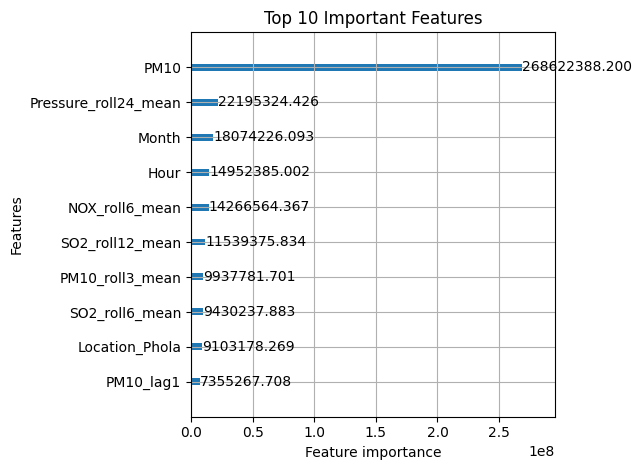

In [14]:
lgb.plot_importance(model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()

In [15]:
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)

xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
# Step 4: Evaluate
def evaluate_model(model, X, y, label):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    print(f'{label} R²: {r2:.4f}')
    print(f'{label} RMSE: {rmse:.4f}')
    return y_pred

print("📊 2017 Test Results")
y_test_pred = evaluate_model(xgb_model, X_test, y_test, '2017 Test')

print("\n📊 2018 Validation Results")
y_val_pred = evaluate_model(xgb_model, X_val, y_val, '2018 Validation')


📊 2017 Test Results
2017 Test R²: 0.5056
2017 Test RMSE: 22.8587

📊 2018 Validation Results
2018 Validation R²: 0.3311
2018 Validation RMSE: 16.2586


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Model performance is still poor for future forecasting, however the margin of error on the validation data is about 10 ug/m^3 which is not that large.
## It might be a better idea to rather predict in what range the PM2.5 value would be in instead and build a classifier around that

In [17]:
features = [
    'Hour', 'Month', 'DayOfWeek', 'Wind', 'Wind_lag1',
       'Wind_roll3_mean', 'Wind_roll6_mean', 'Wind_roll12_mean',
       'Wind_roll24_mean', 'Pressure', 'Pressure_lag1', 'Pressure_roll3_mean',
       'Pressure_roll6_mean', 'Pressure_roll12_mean', 'Pressure_roll24_mean',
       'Temp', 'Temp_lag1', 'Temp_roll3_mean', 'Temp_roll6_mean',
       'Temp_roll12_mean', 'Temp_roll24_mean', 'SO2', 'SO2_lag1',
       'SO2_roll3_mean', 'SO2_roll6_mean', 'SO2_roll12_mean',
       'SO2_roll24_mean', 'NO2', 'NO2_lag1', 'NO2_roll3_mean',
       'NO2_roll6_mean', 'NO2_roll12_mean', 'NO2_roll24_mean', 'NOX',
       'NOX_lag1', 'NOX_roll3_mean', 'NOX_roll6_mean', 'NOX_roll12_mean',
       'NOX_roll24_mean', 'PM10', 'PM10_lag1', 'PM10_roll3_mean',
       'PM10_roll6_mean', 'PM10_roll12_mean', 'PM10_roll24_mean',
       'PM2.5_lag1', 'PM2.5_roll3_mean', 'PM2.5_roll6_mean',
       'PM2.5_roll12_mean', 'PM2.5_roll24_mean', 'Location_Chicken Farm',
       'Location_Marapong', 'Location_Phola', 'Season_Autumn', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'Year'
]


In [18]:
# data_for_model = data_for_model.dropna()
# data_for_model.drop(columns=['PM2.5_lag1', 'PM2.5_roll3_mean', 'PM2.5_roll6_mean',
#        'PM2.5_roll12_mean', 'PM2.5_roll24_mean'], inplace=True)

# data_for_model

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

#data_for_model[features]

# Scale all input features (exclude DateTime and target)
scaled_features = scaler_X.fit_transform(data_for_model[features])

# Scale target separately
scaled_target = scaler_y.fit_transform(data_for_model[['PM2.5']])



In [20]:
print(data_for_model[features])

        Hour  Month  DayOfWeek      Wind  Wind_lag1  Wind_roll3_mean  \
0         20      1          4  5.013026   6.535129         5.808405   
1         20      1          4  4.576110   5.013026         5.374755   
2         20      1          4  5.604620   4.576110         5.064585   
3         20      1          4  4.630336   5.604620         4.937022   
4         20      1          4  4.861779   4.630336         5.032245   
...      ...    ...        ...       ...        ...              ...   
289473    22     12          0  1.579270   1.871147         1.752186   
289474    23     12          0  1.250643   1.579270         1.567020   
289475    23     12          0  1.630720   1.250643         1.486878   
289476    23     12          0  1.238557   1.630720         1.373307   
289477    23     12          0  1.462813   1.238557         1.444030   

        Wind_roll6_mean  Wind_roll12_mean  Wind_roll24_mean  Pressure  \
0              5.669708          5.005227          5.390149   

In [21]:
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(time_steps, len(X)):
        Xs.append(X[i-time_steps:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X, y = create_sequences(scaled_features, scaled_target, time_steps=24)


In [22]:
# -------------------------------------
# 3️⃣ Train/Test Split (No Shuffle)
# -------------------------------------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Confirm shapes (for LSTM input)
print(X_train.shape)  # (samples, timesteps=24, features)
print(X_test.shape)   # (samples, timesteps=24, features)

# -----------------------------
# 4️⃣ Build Lightweight LSTM Model
# -----------------------------
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# -----------------------------------
# 5️⃣ EarlyStopping for Faster Training
# -----------------------------------
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# ---------------------------
# 6️⃣ Train the Model (Faster)
# ---------------------------
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

(231563, 24, 58)
(57891, 24, 58)


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3619/3619 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 0.0023 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/50
3619/3619 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 3.2237e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 3/50
3619/3619 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 2.7181e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/50
3619/3619 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 2.5740e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/50
3612/3619 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5099e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3619/3619 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - loss: 2.5098e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 6/50
3619/3619 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 2.2902e-04 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 7/50
3619/3619 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 2.1884e-04 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 8/50
3615/3619 ━━━━━━━━━━━━━━━━━━

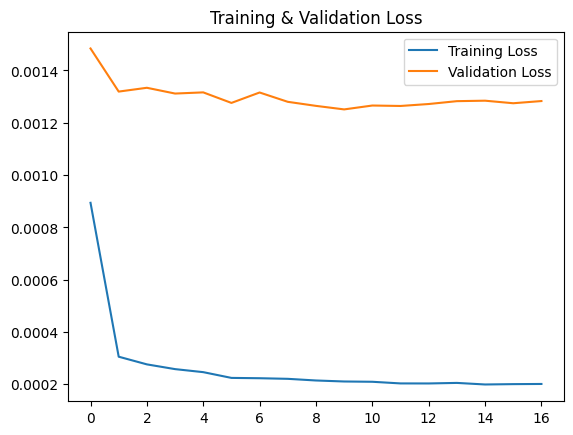

In [23]:
# ---------------------------
# 7️⃣ Plot Loss Curves
# ---------------------------
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()



1810/1810 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


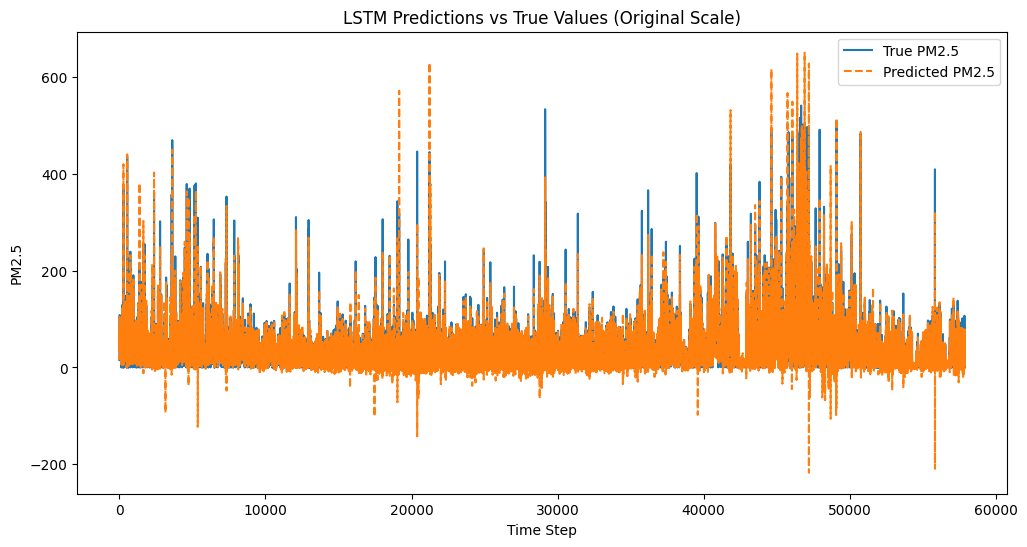

In [24]:

y_test_inverse = scaler_y.inverse_transform(y_test)
y_pred = model.predict(X_test)
y_pred_inverse = scaler_y.inverse_transform(y_pred)

plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse.flatten(), label='True PM2.5')
plt.plot(y_pred_inverse.flatten(), label='Predicted PM2.5', linestyle='--')
plt.title('LSTM Predictions vs True Values (Original Scale)')
plt.xlabel('Time Step')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [25]:
y_pred = model.predict(X_test)
X_test
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

from sklearn.metrics import mean_squared_error, r2_score
print('R²:', r2_score(y_test_rescaled, y_pred_rescaled))
print('RMSE:', mean_squared_error(y_test_rescaled, y_pred_rescaled, squared=False))
 

1810/1810 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
R²: 0.807124999766248
RMSE: 19.160525541171367


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1810/1810 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


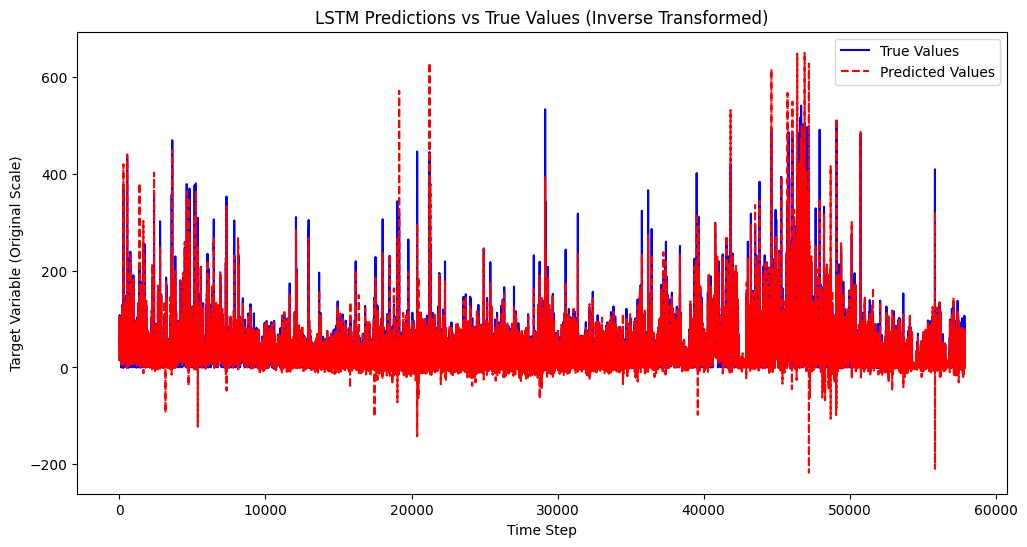

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform if scaling was applied to y
# Make sure scaler was fitted on y_train originally
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler_y.inverse_transform(y_pred)

# Flatten for plotting
y_test_flat = y_test_inverse.flatten()
y_pred_flat = y_pred_inverse.flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='True Values', color='blue')
plt.plot(y_pred_flat, label='Predicted Values', color='red', linestyle='--')
plt.title('LSTM Predictions vs True Values (Inverse Transformed)')
plt.xlabel('Time Step')
plt.ylabel('Target Variable (Original Scale)')
plt.legend()
plt.show()


In [27]:
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.6)
plt.plot([y_test_flat.min(), y_test_flat.max()], [y_test_flat.min(), y_test_flat.max()], 'r--')
plt.title('True vs Predicted (Original Scale)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()


NameError: name 'y_test_flat' is not defined

<Figure size 600x600 with 0 Axes>